In [1]:
import os
import sys
os.chdir('../apps')

In [2]:
from flask import render_template
from flask import request
from flaskexample import app
from sqlalchemy import create_engine
import pandas as pd
import psycopg2
import yaml
from flaskexample.support_functions import formatted_query

In [3]:

ymlfile = open("../configs.yml", 'r')
cfg = yaml.load(ymlfile)
ymlfile.close()

dbname = cfg['dbname']
user = cfg['username']
host = 'localhost'
db = create_engine('postgres://%s%s/%s' % (user, host, dbname))
con = None
con = psycopg2.connect(database=dbname, user=user)



In [4]:
subject = "'Health'"
q_str = """
SELECT nyb.bill_num, nyb.bill_name, ts.logistic
FROM ny_score as ts
INNER JOIN ny_bills as nyb
ON nyb.bill_num=ts.bill_num
WHERE ts.subject={0}
AND ts.logistic IS NOT NULL
ORDER BY ts.logistic DESC
LIMIT 100;
"""
q_fill = q_str.format(subject)
query_results = pd.read_sql_query(q_fill, con)



In [5]:
subject

"'Health'"

In [43]:
bills = []
for i in range(0, query_results.shape[0]):
    bills.append(dict(bill_num=query_results.iloc[i]['bill_num'],
                      bill_name=query_results.iloc[i]['bill_name'],
                      score=query_results.iloc[i]['logistic']))


In [77]:
seen = set()
uniq_bills = dict()
for bill in bills:
    if bill['bill_name'] not in seen:
        uniq_bills[bill['bill_name']] = dict(bill_num=[bill['bill_num']], bill_name=bill['bill_name'], 
                                             score=bill['score'])
        seen.add(bill['bill_name'])
    else:
        b1 = uniq_bills[bill['bill_name']]
        b1['score']= (b1['score'] * len(b1['bill_num']) + bill['score'])/(len(b1['bill_num']) + 1)
        b1['bill_num'].append(bill['bill_num'])
        

In [78]:
sorted_bills = sorted(uniq_bills.values(), key=lambda a: -a['score'])

In [79]:
for bill in sorted_bills:
    bill['score'] = "{0:2.2g}".format(bill['score'])

In [80]:
sorted_bills

[{'bill_name': 'Honoring Chandler M. Ralph upon the occasion of her designation as recipient of the Dr. Edward L. Trudeau Award by the Adirondack Health Foundation',
  'bill_num': ['J6488', 'K1566'],
  'score': ' 1'},
 {'bill_name': 'Provides for patient access to FDA approved abuse-deterrent technology to help combat opioid abuse',
  'bill_num': ['A9487'],
  'score': ' 1'},
 {'bill_name': 'Relates to establishing protections from excessive hospital emergency charges; repealer',
  'bill_num': ['A10470'],
  'score': ' 1'},
 {'bill_name': 'Requires health care plans and insurers to provide expedited review of applications of health care professionals who are joining a group practice',
  'bill_num': ['S2545D'],
  'score': ' 1'},
 {'bill_name': 'Relates to payments from the New York state medical indemnity fund',
  'bill_num': ['A9835B'],
  'score': '0.99'},
 {'bill_name': 'Makes the restrictions relating to smoking in public areas applicable to electronic cigarettes',
  'bill_num': ['A595

In [92]:
def collect_format_sort(results, col):
    bills = []
    for i in range(0, query_results.shape[0]):
        bills.append(dict(bill_num=query_results.iloc[i]['bill_num'],
                          bill_name=query_results.iloc[i]['bill_name'],
                          score=query_results.iloc[i][col]))
    seen = set()
    uniq_bills = dict()
    for bill in bills:
        if bill['bill_name'] not in seen:
            uniq_bills[bill['bill_name']] = dict(bill_num=[bill['bill_num']], bill_name=bill['bill_name'], 
                                                 score=bill['score'])
            seen.add(bill['bill_name'])
        else:
            b1 = uniq_bills[bill['bill_name']]
            b1['score']= (b1['score'] * len(b1['bill_num']) + bill['score'])/(len(b1['bill_num']) + 1)
            b1['bill_num'].append(bill['bill_num'])
            
    sorted_bills = sorted(uniq_bills.values(), key=lambda a: -a['score'])
    for bill in sorted_bills:
        bill['score'] = "{0:2.2g}".format(bill['score'])
        bill['bill_num'] = ", ".join(bill['bill_num'])
    return sorted_bills

In [93]:
display_bills = collect_format_sort(query_results, 'logistic')

In [94]:
display_bills[0:10]

[{'bill_name': 'Honoring Chandler M. Ralph upon the occasion of her designation as recipient of the Dr. Edward L. Trudeau Award by the Adirondack Health Foundation',
  'bill_num': 'J6488, K1566',
  'score': ' 1'},
 {'bill_name': 'Provides for patient access to FDA approved abuse-deterrent technology to help combat opioid abuse',
  'bill_num': 'A9487',
  'score': ' 1'},
 {'bill_name': 'Relates to establishing protections from excessive hospital emergency charges; repealer',
  'bill_num': 'A10470',
  'score': ' 1'},
 {'bill_name': 'Requires health care plans and insurers to provide expedited review of applications of health care professionals who are joining a group practice',
  'bill_num': 'S2545D',
  'score': ' 1'},
 {'bill_name': 'Relates to payments from the New York state medical indemnity fund',
  'bill_num': 'A9835B',
  'score': '0.99'},
 {'bill_name': 'Makes the restrictions relating to smoking in public areas applicable to electronic cigarettes',
  'bill_num': 'A5955B',
  'score

In [7]:
import matplotlib.pyplot as plt

/Users/Joel/anaconda/envs/insight/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
#query_results.plot(kind='barh', legend=None, figsize=figsize)
plt.ylabel("Unique Words", size=label_size)
plt.xlabel("Word Count", size=label_size)
plt.yticks(size=label_size)
plt.xticks(size=label_size)
plt.title("Word Counts for Top 20 Words in Bills for 114th U.S. Congress", size=label_size)

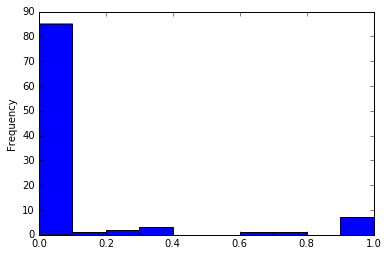

In [11]:
%matplotlib inline
query_results.plot(kind='hist', legend=None)

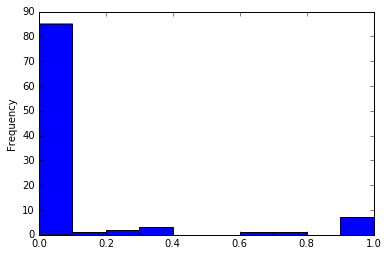

In [37]:
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import StringIO
import base64
from matplotlib.backends.backend_agg import FigureCanvasAgg #canvas

plt.clf()
fig=Figure()
ax=fig.add_subplot(111)
query_results.plot(kind='hist', legend=None)
#canvas=FigureCanvas(fig)
canvas = FigureCanvasAgg(fig) #create the canvas
png_output = StringIO.StringIO()
canvas.print_png(png_output)
png_output = base64.standard_b64encode(png_output.getvalue())

In [38]:
png_output

'iVBORw0KGgoAAAANSUhEUgAAAeAAAAFACAYAAABkyK97AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAMTQAADE0B0s6tTgAAEMBJREFUeJzt3G+I5ed53+HvLW02tLJn+gfVkevd2kKVKuPYOHJMqduASctg4ia1rZImbYjAbiIjAjUlMt0XTlWoX6hvHOwESZhGSxCxXatJTZJqAjUYooDSIJFF/iO7SLY28jY4Lp1RVdwl3rsvZtRMN7urM6vdc58ZXRcI9nf0zOGeRzrnM8/ZM6e6OwDAcl0zPQAAvBIJMAAMEGAAGCDAADBAgAFggAADwAABBoABAgwAAwQYAAYIMAAMEGAAGCDAADBAgAFggAADwAABBoABAgwAAwQYAAYIMAAMEGAAGCDAADBAgAFggAADwAABBoABAgwAAwQYAAYIMAAMWOkAV9UvVtUzVXWuqt58iXXvrqovV9VTVfXZqnrVMucEgP1a6QAn+Q9J3pHk6xdbUFXXJflkkh/t7luSnEnykaVMBwCXaaUD3N2/293fTFKXWPauJI9399d2r385yU9c9eEA4GVY6QAv6HiSb+y5/nqS76uqw/C9AXBIHZkeYJmqqpK8Nsnz07MA8LK9Osk3u7unB7kchyHAzyb5B3uu35DkTHefu8Da1yb5o6VMBcAyvC7Jc9NDXI7DEOBHknyiqm7u7q8m+WCST11k7fNJcvr06aytrS1rvgPpxIkT+ehHPzo9xoFgrxZjnxZnr17a9vZ2jh07lhzgVzRXOsBVdV+SH0nymiSbVfV8d99cVfckea67H+ju/1VVH0jyn6rq2iRPJvnpS93v2tqaAL+Eo0eP2qMF2avF2KfF2atXhpUOcHffeZHbf+G8699M8ptLGQoArgDvFOaCNjY2pkc4MOzVYuzT4uzVK0Md0DePXZaqWkuytbW15eUdgANse3s76+vrSbLe3dvT81wOJ2AAGCDAADBAgAFggAADwAABBoABAgwAAwQ

In [22]:
import matplotlib

In [ ]:
matplotlib.pyplot.FigureCanvasBase.

In [30]:
import wx

ImportError: No module named wx